# Step 1: Import Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import os
import kagglehub

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Step 2: Download and Load Data from Kaggle

In [3]:
# Download latest version from Kaggle
dataset_path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")
print("Path to dataset files:", dataset_path)

# Load data (adjust file names based on what's available in the dataset)
train_file = os.path.join(dataset_path, "train.csv")
test_file = os.path.join(dataset_path, "test.csv")

100%|██████████| 54.4M/54.4M [00:00<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [4]:
train_df = pd.read_csv(train_file, encoding="latin1")
test_df = pd.read_csv(test_file, encoding="latin1")

In [5]:
# Display a few rows
print("Training data sample:")
display(train_df.sample(3))
print("\nTest data sample:")
display(test_df.sample(2))

Training data sample:


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
20141,4df6ba1655,I`m at mcdonalds eating chicken nuggets with m...,so embarrased,negative,night,70-100,Morocco,36910560,446300.0,83
9891,3671b52421,Hey Bye Bye was fun too (robluketic live >...,s fun,positive,morning,46-60,Congo (Congo-Brazzaville),5518087,342000.0,16
25221,f3695fc09e,"Oh, ouch. That hurt. **** washing machine is ...",hurt.,negative,morning,46-60,Bahrain,1701575,760.0,2239



Test data sample:


,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
977,78094a1191,miss you captain,negative,night,70-100,Algeria,43851044.0,2381740.0,18.0
1041,213eae85e9,I`m part of a religion called People-With-Goo...,neutral,morning,46-60,Kazakhstan,18776707.0,2699700.0,7.0


In [6]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (27481, 10)
Testing data shape: (4815, 9)


# Step 3: Data Preprocessing

In [7]:
train_df = pd.DataFrame(train_df[['text', 'sentiment']])
test_df = pd.DataFrame(test_df[['text', 'sentiment']])

In [8]:
# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())


Missing values in training data:
text         1
sentiment    0
dtype: int64

Missing values in test data:
text         1281
sentiment    1281
dtype: int64


In [9]:
# Handle missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

In [10]:
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())


Missing values in training data:
text         0
sentiment    0
dtype: int64

Missing values in test data:
text         0
sentiment    0
dtype: int64


In [11]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (27480, 2)
Testing data shape: (3534, 2)


In [12]:
# Check unique sentiment values
unique_sentiments = set(train_df["sentiment"].unique()) | set(test_df["sentiment"].unique())
print(f"\nUnique sentiment values: {unique_sentiments}")


Unique sentiment values: {'negative', 'neutral', 'positive'}


In [13]:
sentiment_map = {sentiment: i for i, sentiment in enumerate(unique_sentiments)}
sentiment_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [14]:
# Map sentiment labels to integers
train_df['label'] = train_df["sentiment"].map(sentiment_map)
test_df['label'] = test_df["sentiment"].map(sentiment_map)

<ipython-input-14-b3fe40dce97e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['label'] = test_df["sentiment"].map(sentiment_map)


In [15]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
print("\nAfter splitting:")
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Check label distribution
print("\nTraining data label distribution:")
print(train_df['label'].value_counts())
print("\nValidation data label distribution:")
print(val_df['label'].value_counts())
print("\nTest data label distribution:")
print(test_df['label'].value_counts())


After splitting:
Training data shape: (21984, 3)
Validation data shape: (5496, 3)
Testing data shape: (3534, 3)

Training data label distribution:
label
1    8894
2    6865
0    6225
Name: count, dtype: int64

Validation data label distribution:
label
1    2223
2    1717
0    1556
Name: count, dtype: int64

Test data label distribution:
label
1    1430
2    1103
0    1001
Name: count, dtype: int64


# Step 4: Create Dataset Class

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Step 5: Create Datasets and DataLoaders

In [17]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Create datasets
train_dataset = SentimentDataset(
    texts=train_df["text"].tolist(),
    labels=train_df['label'].tolist(),
    tokenizer=tokenizer
)

val_dataset = SentimentDataset(
    texts=val_df["text"].tolist(),
    labels=val_df['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = SentimentDataset(
    texts=test_df["text"].tolist(),
    labels=test_df['label'].tolist(),
    tokenizer=tokenizer
)

# Check dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training dataset size: 21984
Validation dataset size: 5496
Test dataset size: 3534


In [18]:
batch_size = 32
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Step 6: Set up Model, Optimizer and hyperparameters

In [19]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(sentiment_map),
    problem_type="single_label_classification"
)
model.to(device)
print(f"Model {model_name} loaded successfully with {len(sentiment_map)} output classes!")

# Set hyperparameters
epochs = 5
learning_rate = 3e-5
weight_decay = 0.01

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
total_steps = len(train_loader) * epochs
warmup_steps = len(train_loader) // 10  # 10% of steps for warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model bert-base-uncased loaded successfully with 3 output classes!


# Step 7: Define Training,Evaluation Functions

In [20]:
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
label_names = [reverse_sentiment_map.get(i, f"Class {i}") for i in range(len(sentiment_map))]

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'test_loss': [],
    'val_accuracy': [],
    'test_accuracy': [],
    'val_precision': {label: [] for label in label_names},
    'val_recall': {label: [] for label in label_names},
    'val_f1': {label: [] for label in label_names}
}

# Add GPU memory monitoring
if torch.cuda.is_available():
    history['gpu_memory_usage'] = []

# Training loop
print("Starting training...")
print(f"Number of labels: {len(sentiment_map)}")
print(f"Label mapping: {sentiment_map}")
print(f"Label names: {label_names}")

Starting training...
Number of labels: 3
Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Label names: ['negative', 'neutral', 'positive']


In [21]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    progress_interval = max(1, len(data_loader) // 5)  # Update every 20%

    for batch_idx, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        running_loss += loss.item()

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()
        scheduler.step()

        # Print progress
        if (batch_idx + 1) % progress_interval == 0:
            print(f"Batch {batch_idx+1}/{len(data_loader)} | Loss: {loss.item():.4f}")

    # Calculate average loss
    epoch_loss = running_loss / len(data_loader)
    return epoch_loss

def evaluate_model(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Get predictions
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            # Store predictions and labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Calculate metrics
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    # Calculate precision, recall, f1-score per class
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_predictions


#Step 8 : Training

In [22]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 50)

    # Train one epoch
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    history['train_loss'].append(train_loss)

    # Monitor GPU memory if available
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated(0) / 1e9  # in GB
        history['gpu_memory_usage'].append(memory_allocated)
        print(f"GPU Memory Usage: {memory_allocated:.2f} GB")

    # Evaluate on validation set
    val_loss, val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate_model(model, val_loader, device)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    # Evaluate on test set
    test_loss, test_accuracy, _, _, _, _, _ = evaluate_model(model, test_loader, device)
    history['test_loss'].append(test_loss)
    history['test_accuracy'].append(test_accuracy)

    # Store precision and recall for each class
    for i, label in enumerate(label_names):
        if i < len(val_precision):
            history['val_precision'][label].append(val_precision[i])
            history['val_recall'][label].append(val_recall[i])
            history['val_f1'][label].append(val_f1[i])

    # Print epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    # Print per-class metrics
    print("\nPer-class Validation Metrics:")
    print("-" * 50)
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)
    for i, label in enumerate(label_names):
        if i < len(val_precision):
            print(f"{label:<15} {val_precision[i]:.4f}{' ':6} {val_recall[i]:.4f}{' ':6} {val_f1[i]:.4f}")
    print("-" * 50)


Epoch 1/5
--------------------------------------------------
Batch 137/687 | Loss: 0.7178
Batch 274/687 | Loss: 0.5196
Batch 411/687 | Loss: 0.7199
Batch 548/687 | Loss: 0.5490
Batch 685/687 | Loss: 0.6505
GPU Memory Usage: 1.84 GB
Training Loss: 0.6087
Validation Loss: 0.5269 | Validation Accuracy: 0.7838
Test Loss: 0.5101 | Test Accuracy: 0.7881

Per-class Validation Metrics:
--------------------------------------------------
Class           Precision  Recall     F1-Score  
--------------------------------------------------
negative        0.7603       0.8156       0.7870
neutral         0.7647       0.7238       0.7437
positive        0.8299       0.8328       0.8314
--------------------------------------------------

Epoch 2/5
--------------------------------------------------
Batch 137/687 | Loss: 0.3103
Batch 274/687 | Loss: 0.2603
Batch 411/687 | Loss: 0.2970
Batch 548/687 | Loss: 0.6069
Batch 685/687 | Loss: 0.2617
GPU Memory Usage: 1.84 GB
Training Loss: 0.4063
Validation Los

# Step  9: Plot Training History

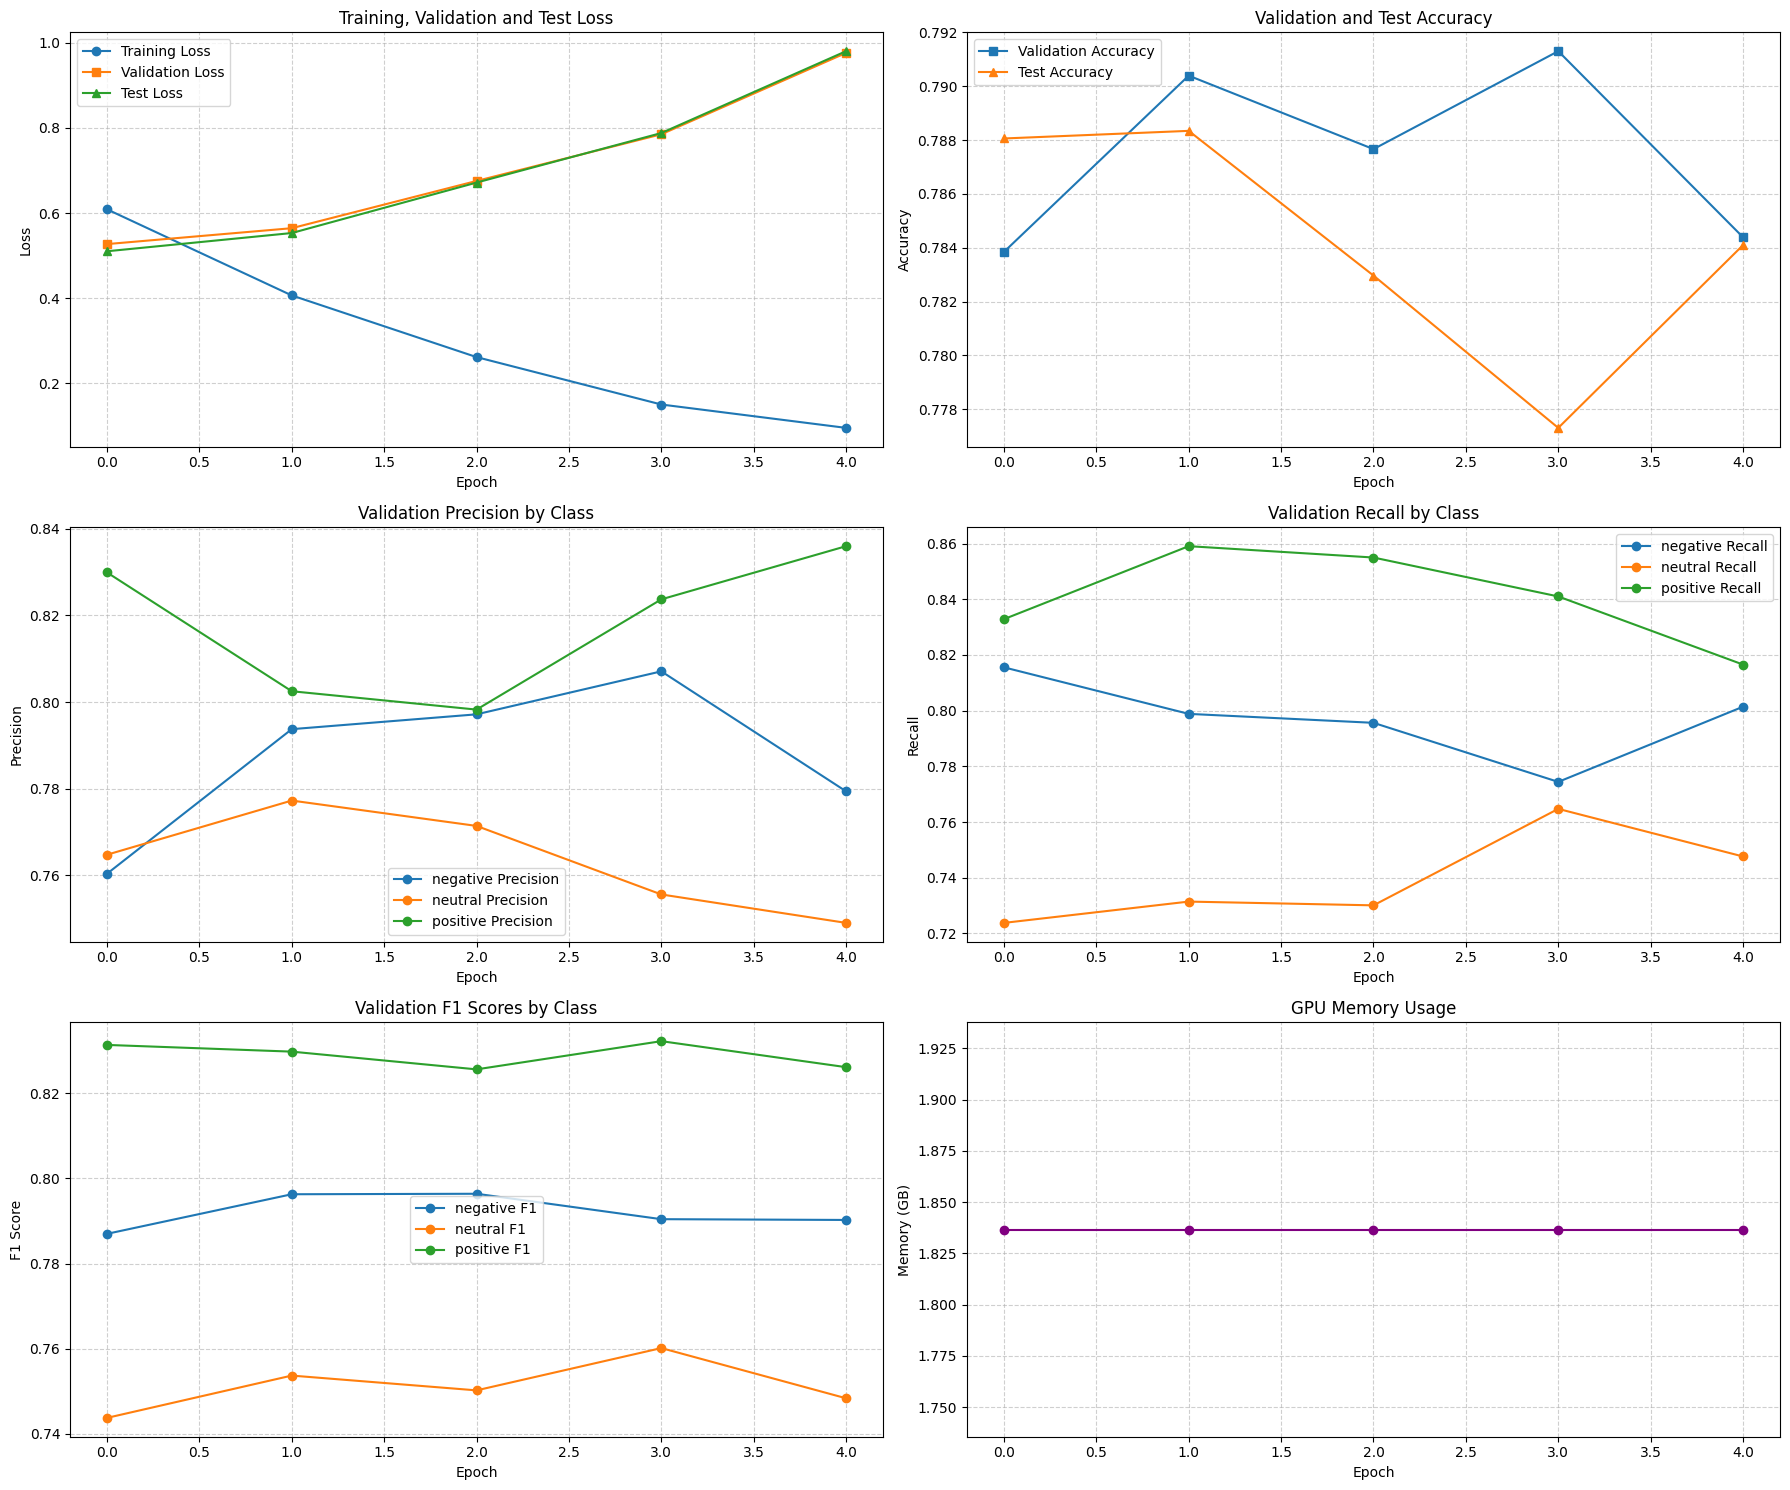

In [23]:
plt.figure(figsize=(18, 15))

# Plot loss curves
plt.subplot(3, 2, 1)
plt.plot(history['train_loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.plot(history['test_loss'], label='Test Loss', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot accuracy curve
plt.subplot(3, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.plot(history['test_accuracy'], label='Test Accuracy', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot precision for each class
plt.subplot(3, 2, 3)
for label in label_names:
    if history['val_precision'][label]:  # Check if we have data for this class
        plt.plot(history['val_precision'][label], label=f'{label} Precision', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Validation Precision by Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot recall for each class
plt.subplot(3, 2, 4)
for label in label_names:
    if history['val_recall'][label]:  # Check if we have data for this class
        plt.plot(history['val_recall'][label], label=f'{label} Recall', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Validation Recall by Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot F1 scores for each class
plt.subplot(3, 2, 5)
for label in label_names:
    if history['val_f1'][label]:  # Check if we have data for this class
        plt.plot(history['val_f1'][label], label=f'{label} F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Scores by Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot GPU memory usage if available
if torch.cuda.is_available() and 'gpu_memory_usage' in history:
    plt.subplot(3, 2, 6)
    plt.plot(history['gpu_memory_usage'], label='GPU Memory', marker='o', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Memory (GB)')
    plt.title('GPU Memory Usage')
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('training_metrics_gpu.png')  # Save the plots
plt.show()

# Step 10: Final Evaluation and Metrics

Final Classification Report on Test Set:
              precision    recall  f1-score   support

    negative       0.77      0.81      0.79      1001
     neutral       0.76      0.74      0.75      1430
    positive       0.83      0.82      0.83      1103

    accuracy                           0.78      3534
   macro avg       0.79      0.79      0.79      3534
weighted avg       0.78      0.78      0.78      3534


Final Per-class Test Metrics:
--------------------------------------------------
Class           Precision  Recall     F1-Score  
--------------------------------------------------
negative        0.7737       0.8062       0.7896
neutral         0.7555       0.7392       0.7473
positive        0.8306       0.8223       0.8264
--------------------------------------------------


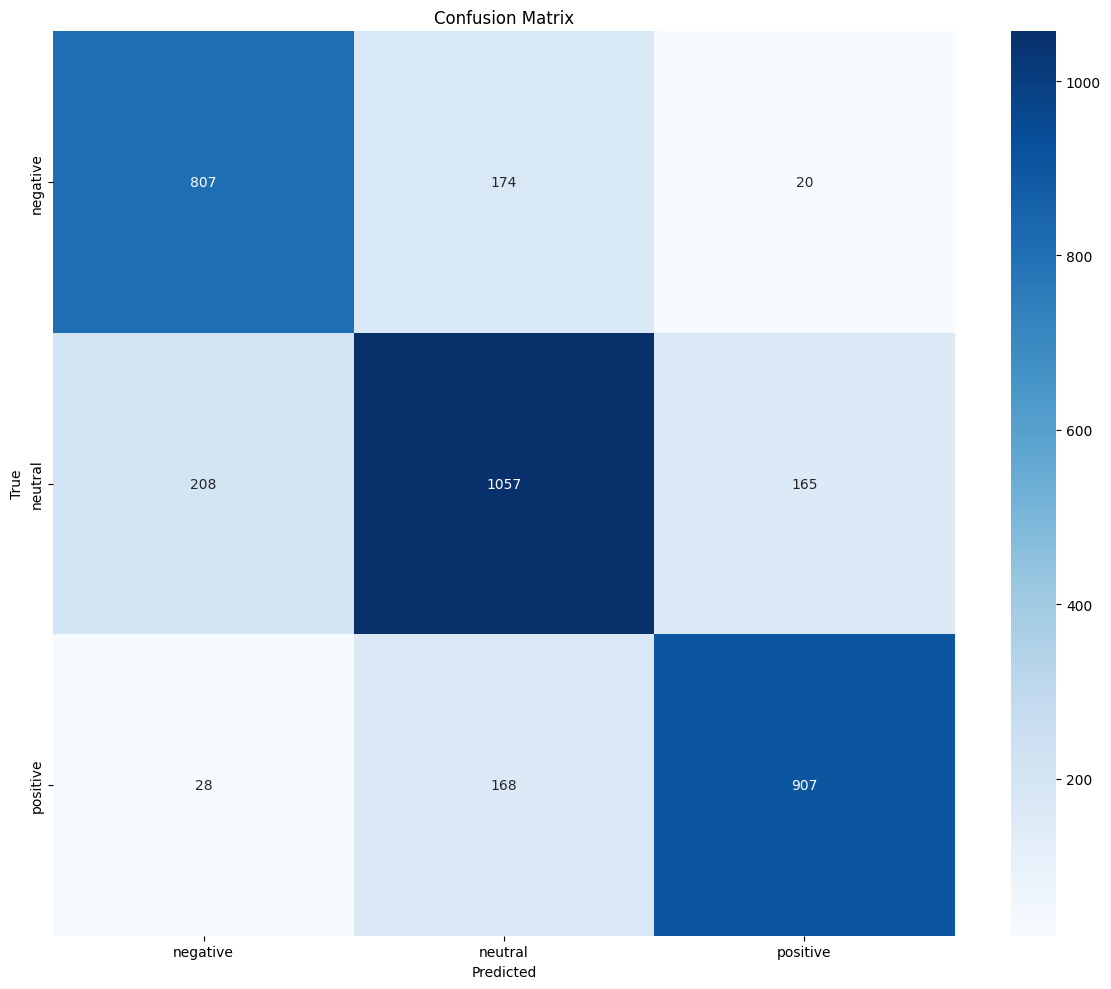

In [24]:
model.eval()
_, _, test_precision, test_recall, test_f1, all_labels, all_predictions = evaluate_model(model, test_loader, device)

# Classification report
print("Final Classification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=label_names))

# Print final per-class metrics
print("\nFinal Per-class Test Metrics:")
print("-" * 50)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 50)
for i, label in enumerate(label_names):
    if i < len(test_precision):
        print(f"{label:<15} {test_precision[i]:.4f}{' ':6} {test_recall[i]:.4f}{' ':6} {test_f1[i]:.4f}")
print("-" * 50)

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_gpu.png')  # Save the confusion matrix
plt.show()

# Step 11: Example Prediction Function

In [25]:
def predict_sentiment(text, model, tokenizer, reverse_sentiment_map, device):
    """Make sentiment prediction on a single text with confidence scores"""
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        confidence, preds = torch.max(probs, dim=1)

    # Map prediction to sentiment
    predicted_class = preds.item()
    predicted_sentiment = reverse_sentiment_map.get(predicted_class, f"Class {predicted_class}")
    confidence_score = confidence.item()

    # Get all class probabilities
    all_probs = probs[0].cpu().numpy()
    class_probs = {reverse_sentiment_map.get(i, f"Class {i}"): prob for i, prob in enumerate(all_probs)}

    return predicted_sentiment, confidence_score, class_probs

# Test the prediction function
test_texts = [
    "I absolutely loved this product, it was fantastic!",
    "The product was okay, nothing special.",
    "This was the worst experience ever, I'm very disappointed."
]

print("\nExample Predictions:")
print("-" * 50)
for text in test_texts:
    sentiment, confidence, class_probs = predict_sentiment(text, model, tokenizer, reverse_sentiment_map, device)
    print(f"Text: '{text}'")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})")
    print("Class probabilities:")
    for cls, prob in class_probs.items():
        print(f"  - {cls}: {prob:.4f}")
    print("-" * 30)


Example Predictions:
--------------------------------------------------
Text: 'I absolutely loved this product, it was fantastic!'
Predicted sentiment: positive (confidence: 0.9972)
Class probabilities:
  - negative: 0.0021
  - neutral: 0.0007
  - positive: 0.9972
------------------------------
Text: 'The product was okay, nothing special.'
Predicted sentiment: neutral (confidence: 0.9960)
Class probabilities:
  - negative: 0.0012
  - neutral: 0.9960
  - positive: 0.0028
------------------------------
Text: 'This was the worst experience ever, I'm very disappointed.'
Predicted sentiment: negative (confidence: 0.9967)
Class probabilities:
  - negative: 0.9967
  - neutral: 0.0015
  - positive: 0.0019
------------------------------
